# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [1]:
!pip install -r /content/requirements.txt

In [2]:
!pip install kaggle

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/ .kaggle

In [4]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [5]:
!chmod 600 ~/ .kaggle/kaggle.json

In [6]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
 84% 25.0M/29.6M [00:00<00:00, 57.2MB/s]
100% 29.6M/29.6M [00:00<00:00, 61.2MB/s]


In [7]:
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

Archive:  /content/semantic-segmentation-of-aerial-imagery.zip
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_001.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_002.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_003.png  
  in

In [13]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


In [14]:
import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(42)

2.12.1


In [15]:
PATH  = "/content/Semantic segmentation dataset"

In [11]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

In [ ]:
#PATCH_GENERATOR.image_dataset

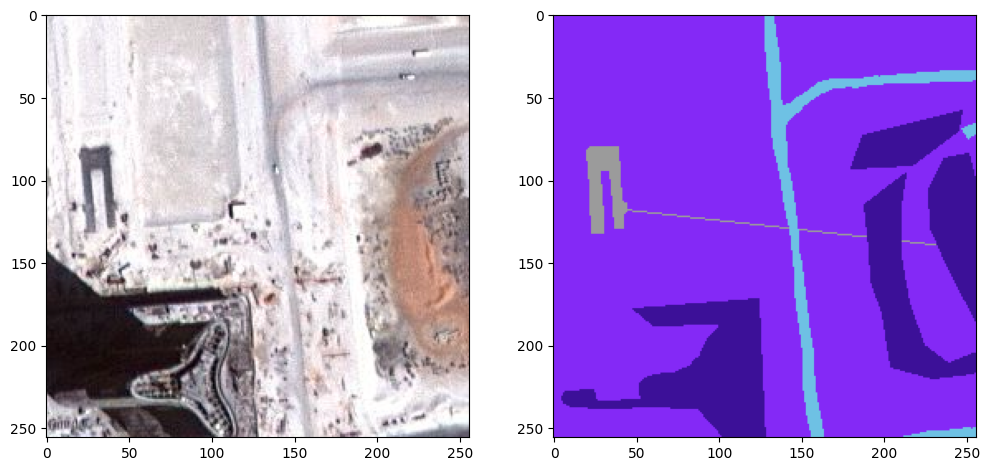

In [20]:
PATCH_GENERATOR.check()

In [21]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels

In [22]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [23]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [24]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [25]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [26]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


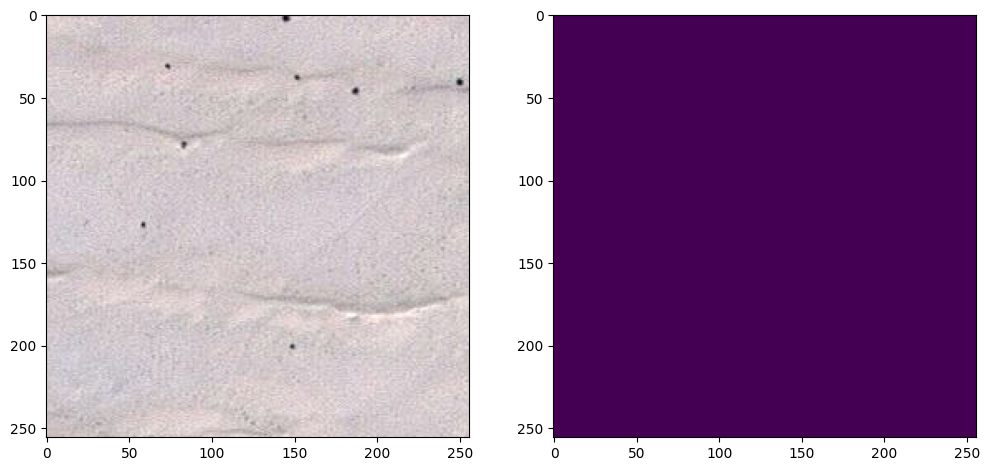

In [27]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [28]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

## NEXT STEPS:

- Grid search for hyperparameter tuning following university procedure;
- review U-net concepts
- compare with other pretrained models


# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
  1. Accuracy is still going up, train the models more;
  2. Huge train/ val gap means overfiiting: increase regularization or more data
  3. No gap betwee train/val means underfitting: train longer or a bigger model
7. Go back to step 5 if needed (refine grid search)

In [30]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [31]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


1. Check initial loss

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=1,
                    shuffle=False)

In [37]:
tf.keras.backend.clear_session()

2. Overfit a small sample

In [34]:
sample_imgs.shape

(6, 256, 256, 3)

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history2 = model.fit(sample_imgs, sample_labels,
                    batch_size = 32,
                    verbose=1,
                    epochs=1000,
                    shuffle=False)

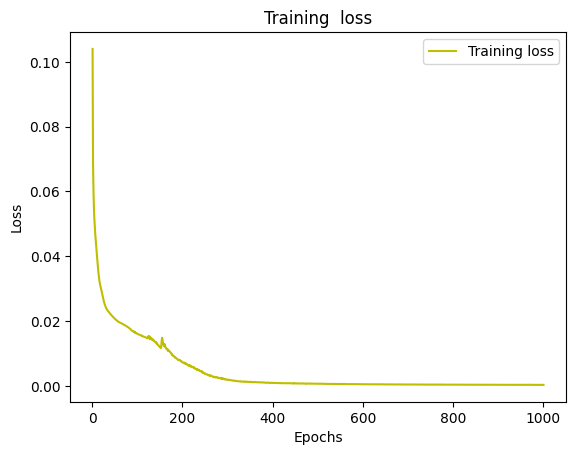

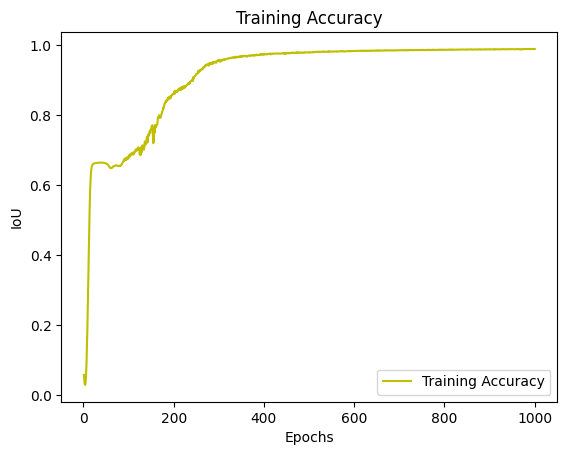

In [36]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

3. Grid-Search (for 100 iterations)

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from scikeras.wrappers import KerasClassifier

In [ ]:
X_train.shape

(1044, 256, 256, 3)

In [38]:
import math
# dividing by 2 due to the cv
num_samples = 1044
batch_size = 32

# Calculate the number of epochs to reach the total iterations
batches_per_epoch = math.ceil(num_samples / batch_size) # this is equal to the number of iteration in a epoch
batches_per_epoch

33

In [40]:
# Function used for Grid-search
def define_model(optimizer):
    model = multi_unet_model()
    model.compile(optimizer = optimizer, loss=sm.losses.CategoricalFocalLoss(), metrics=['accuracy'])
    return model


We can't use keras wrapper and grid search here due to shape constraints.

In fact, it is thought for 1D input/output.

We need to do sth else here!
https://adriangb.com/scikeras/stable/notebooks/DataTransformers.html

In [ ]:
#optimizer = ['Adam']
#param_grid = dict(optimizer=["adam"],
                  )
#model = KerasClassifier(model= define_model, optimizer="adam", epochs= 6,input_shape=(256, 256, 3),num_classes=6)

#grid = GridSearchCV(estimator=model, param_grid=param_grid,  verbose = 1, n_jobs=1, cv=2, error_score='raise')

#grid_result = grid.fit(X_train, y_train)

In [ ]:
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
 #   print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

In [43]:
list(ParameterGrid(param_grid))

[{'optimizer': 'adam', 'optimizer__learning_rate': 0.1},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.01},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.001},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.0001}]

In [41]:
import gc
import wandb
# WandbCallback will automatically log history data from any metrics collected by keras: loss and anything passed into keras_model.compile().
from wandb.integration.keras import WandbCallback
from sklearn.model_selection import ParameterGrid

param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
}

results = []
NAME = "GRID_SEARCH_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="FirstGridSearch",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.1}


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/3
33/33 [==============================] - 61s 2s/step - loss: 0.3045 - accuracy: 0.5235
Epoch 2/3
33/33 [==============================] - 56s 2s/step - loss: 0.3105 - accuracy: 0.5376
Epoch 3/3
33/33 [==============================] - 56s 2s/step - loss: 0.3105 - accuracy: 0.5376


accuracy,▁██
epoch,▁▅█
loss,▁██
accuracy,0.53763
epoch,2
loss,0.31052


wandb: Currently logged in as: boesso-simone (simboex). Use `wandb login --relogin` to force relogin


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.01}


Epoch 1/3
33/33 [==============================] - 59s 2s/step - loss: 0.0341 - accuracy: 0.5466
Epoch 2/3
33/33 [==============================] - 55s 2s/step - loss: 0.0248 - accuracy: 0.6278
Epoch 3/3
33/33 [==============================] - 55s 2s/step - loss: 0.0229 - accuracy: 0.6512


accuracy,▁▆█
epoch,▁▅█
loss,█▂▁
accuracy,0.65121
epoch,2
loss,0.02293


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.001}


Epoch 1/3
33/33 [==============================] - 60s 2s/step - loss: 0.0431 - accuracy: 0.3415
Epoch 2/3
33/33 [==============================] - 57s 2s/step - loss: 0.0282 - accuracy: 0.5877
Epoch 3/3
33/33 [==============================] - 56s 2s/step - loss: 0.0226 - accuracy: 0.6570


accuracy,▁▆█
epoch,▁▅█
loss,█▃▁
accuracy,0.65697
epoch,2
loss,0.02261


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.0001}


Epoch 1/3
33/33 [==============================] - 60s 2s/step - loss: 0.0530 - accuracy: 0.1610
Epoch 2/3
33/33 [==============================] - 55s 2s/step - loss: 0.0408 - accuracy: 0.4079
Epoch 3/3
33/33 [==============================] - 55s 2s/step - loss: 0.0347 - accuracy: 0.5100


accuracy,▁▆█
epoch,▁▅█
loss,█▃▁
accuracy,0.50997
epoch,2
loss,0.03474


4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs

In [46]:
list(ParameterGrid(param_grid))

[{'optimizer': 'adam', 'optimizer__learning_rate': 0.0009000000000000001},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.00095},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.001},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.0010500000000000002},
 {'optimizer': 'adam', 'optimizer__learning_rate': 0.0011}]

In [45]:
learning_rate = 0.001
multipliers = [0.9, 0.95, 1.0, 1.05, 1.1]

learning_rates = [learning_rate * m for m in multipliers]

param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': learning_rates,
}

results = []
NAME = "GRID_SEARCH_STEP4_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="FirstGridSearch",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.0009000000000000001}


Epoch 1/5
33/33 [==============================] - 60s 2s/step - loss: 0.0335 - accuracy: 0.5309
Epoch 2/5
33/33 [==============================] - 55s 2s/step - loss: 0.0283 - accuracy: 0.5737
Epoch 3/5
33/33 [==============================] - 56s 2s/step - loss: 0.0230 - accuracy: 0.6560
Epoch 4/5
33/33 [==============================] - 56s 2s/step - loss: 0.0200 - accuracy: 0.7061
Epoch 5/5
33/33 [==============================] - 55s 2s/step - loss: 0.0181 - accuracy: 0.7307


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▆▃▂▁
accuracy,0.73068
epoch,4
loss,0.01806


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.00095}


Epoch 1/5
33/33 [==============================] - 59s 2s/step - loss: 0.0362 - accuracy: 0.4733
Epoch 2/5
33/33 [==============================] - 56s 2s/step - loss: 0.0287 - accuracy: 0.5722
Epoch 3/5
33/33 [==============================] - 55s 2s/step - loss: 0.0258 - accuracy: 0.6383
Epoch 4/5
33/33 [==============================] - 55s 2s/step - loss: 0.0216 - accuracy: 0.6785
Epoch 5/5
33/33 [==============================] - 55s 2s/step - loss: 0.0198 - accuracy: 0.7037


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▄▂▁
accuracy,0.7037
epoch,4
loss,0.0198


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.001}


Epoch 1/5
33/33 [==============================] - 59s 2s/step - loss: 0.0345 - accuracy: 0.5213
Epoch 2/5
33/33 [==============================] - 55s 2s/step - loss: 0.0293 - accuracy: 0.5760
Epoch 3/5
33/33 [==============================] - 55s 2s/step - loss: 0.0267 - accuracy: 0.6055
Epoch 4/5
33/33 [==============================] - 55s 2s/step - loss: 0.0227 - accuracy: 0.6627
Epoch 5/5
33/33 [==============================] - 56s 2s/step - loss: 0.0212 - accuracy: 0.6693


accuracy,▁▄▅██
epoch,▁▃▅▆█
loss,█▅▄▂▁
accuracy,0.66931
epoch,4
loss,0.0212


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.0010500000000000002}


Epoch 1/5
33/33 [==============================] - 59s 2s/step - loss: 0.0364 - accuracy: 0.4977
Epoch 2/5
33/33 [==============================] - 56s 2s/step - loss: 0.0286 - accuracy: 0.5643
Epoch 3/5
33/33 [==============================] - 56s 2s/step - loss: 0.0229 - accuracy: 0.6601
Epoch 4/5
33/33 [==============================] - 57s 2s/step - loss: 0.0201 - accuracy: 0.6928
Epoch 5/5
33/33 [==============================] - 57s 2s/step - loss: 0.0185 - accuracy: 0.7085


accuracy,▁▃▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,0.70846
epoch,4
loss,0.01853


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.0011}


Epoch 1/5
33/33 [==============================] - 59s 2s/step - loss: 0.0315 - accuracy: 0.5283
Epoch 2/5
33/33 [==============================] - 55s 2s/step - loss: 0.0264 - accuracy: 0.5692
Epoch 3/5
33/33 [==============================] - 56s 2s/step - loss: 0.0243 - accuracy: 0.6126
Epoch 4/5
33/33 [==============================] - 55s 2s/step - loss: 0.0205 - accuracy: 0.6999
Epoch 5/5
33/33 [==============================] - 55s 2s/step - loss: 0.0183 - accuracy: 0.7345


accuracy,▁▂▄▇█
epoch,▁▃▅▆█
loss,█▅▄▂▁
accuracy,0.73446
epoch,4
loss,0.0183


5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.

In [ ]:
wandb.init(project="FirstGridSearch",
               name = NAME + "STEP5_ChosenHyperparameters",
               reinit=True,
               )

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0009000000000000001)
model = define_model(optimizer=optimizer)
# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,callbacks=[WandbCallback()])


Epoch 1/20
33/33 [==============================] - 59s 2s/step - loss: 0.0323 - accuracy: 0.5240
Epoch 2/20
 8/33 [======>.......................] - ETA: 41s - loss: 0.0281 - accuracy: 0.5377